In [1]:
!nvidia-smi

Thu Dec 24 04:01:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
cd drive/My Drive/kogaken/mlphase

/content/drive/My Drive/kogaken/mlphase


In [4]:
# coding: utf-8
# import subprocess

import sys
import os
import numpy as np
import json
import pickle
from datetime import datetime
# import itertools
import random
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
%matplotlib inline

# from making_2D_image_20191028 import load_data
# from making_2D_image_20191028 import surf_figure, reduce_pkl_data

# from common.simple_convnet import SimpleConvNet
# from common.trainer import Trainer
# from dataset.mnist import load_mnist
# import matplotlib as mpl

In [5]:
import tensorflow as tf

from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.losses import Huber

from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, concatenate, Conv2DTranspose, ReLU, LeakyReLU, PReLU, ThresholdedReLU
from keras.callbacks import CSVLogger, EarlyStopping
# from keras.datasets import mnist
# from keras.layers import Activation, Dropout, Reshape, SeparableConv2D
# from keras.callbacks import EarlyStopping

# from file_operation import MAKE_DIR, COPY_FILES

# sys.path.append(os.pardir)

In [6]:
folder = "result/2020_1204_182942_elip30_12_4_train20000_test2000"
active_function = "PReLU"
activation = None

# "abs_phase", "abs", "real_imag", "real_imag_abs", "all", "real__imag", "abs__angle", "abs_phase__real_imag", "real_imag__abs", "real_imag__real_imag", "real_imag_abs__angle", "real_imag__abs__angle", "real__imag__abs", "real__imag__abs__angle"
reshape_type="real_imag__abs__angle"

noise_rate = 0

is_normalization = True

is_one_bias = False

optimizer = "adam"

loss = "logcosh"

In [7]:
# def seed_everything(seed=42):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     tf.random.set_seed(seed)
#     session_conf = tf.compat.v1.ConfigProto(
#         intra_op_parallelism_threads=1,
#         inter_op_parallelism_threads=1
#     )
#     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#     tf.compat.v1.keras.backend.set_session(sess)

In [8]:
strtime = datetime.now().strftime("%Y%m%d%H%M" + "-" + "%S")
print("")
print("time=", strtime)

# 保存フォルダの指定,時刻がフォルダの名前になる
if not folder:
    os.makedirs(strtime)
    sfolder = strtime
else:
    sfolder = folder + "/" + strtime
    os.makedirs(sfolder)

mirror_train = folder + "/" + "mirror_train_data.pkl"
detec_train = folder + "/" + "detec_train_data.pkl"

mirror_test = folder + "/" + "mirror_test_data.pkl"
detec_test = folder + "/" + "detec_test_data.pkl"

# seed_everything(43)


time= 202012240402-03


In [9]:
def combine_pkl_data(file1, file2, new_file):

    with open(file1, "rb") as f:
        detec_data = pickle.load(f)
    with open(file2, "rb") as f:
        mirror_data = pickle.load(f)

    i = 0
    data = []
    for e_data in mirror_data["elip"]:
        row = {
            "info": detec_data[i]["info"],
            "z1": detec_data[i]["z"],
            "z2": e_data["z"]
        }
        i += 1
        data.append(row)

    for m_data in mirror_data["mode"]:
        row = {
            "info": detec_data[i]["info"],
            "z1": detec_data[i]["z"],
            "z2": m_data["z"]
        }
        i += 1
        data.append(row)

    new_file += str(i) + ".pkl"

    with open(new_file, 'wb') as f:
        pickle.dump(data, f)

    return new_file, i

In [10]:
def load_data_2(file1, file2):

    new_file = os.path.dirname(file1) + "/" \
        + os.path.basename(file1).split(".")[0] + "_" \
        + os.path.basename(file2).split(".")[0] + "_"

    if not os.path.isfile(new_file):
        print("make combined file: ", new_file)
        new_file, data_num = combine_pkl_data(file1, file2, new_file)

    print("load_data of input", file1, file2)
    print("load_data:", new_file)

    with open(new_file, "rb") as f:
        data = pickle.load(f)

    z1, z2, t = [], [], []

    for d in data:
        z1.append([d["z1"]])
        z2.append([d["z2"]])
        t.append([d["info"]])

    z1 = np.array(z1)
    z2 = np.array(z2)
    t = np.array(t)
    return z1, z2, t, data_num

In [11]:
def load_data(*files):
    # if len(files) == 1:
    #     return load_data_1(files[0], num_data=num_data)
    # elif len(files) == 2:
    #     return load_data_2(files[0], files[1])
    if len(files) == 2:
        return load_data_2(files[0], files[1])
    else:
        print("No Two files!!")
        exit()

In [12]:
x, y, _, train_num = load_data(detec_train, mirror_train)
xt, yt, _, test_num = load_data(detec_test, mirror_test)

make combined file:  result/2020_1204_182942_elip30_12_4_train20000_test2000/detec_train_data_mirror_train_data_
load_data of input result/2020_1204_182942_elip30_12_4_train20000_test2000/detec_train_data.pkl result/2020_1204_182942_elip30_12_4_train20000_test2000/mirror_train_data.pkl
load_data: result/2020_1204_182942_elip30_12_4_train20000_test2000/detec_train_data_mirror_train_data_20000.pkl
make combined file:  result/2020_1204_182942_elip30_12_4_train20000_test2000/detec_test_data_mirror_test_data_
load_data of input result/2020_1204_182942_elip30_12_4_train20000_test2000/detec_test_data.pkl result/2020_1204_182942_elip30_12_4_train20000_test2000/mirror_test_data.pkl
load_data: result/2020_1204_182942_elip30_12_4_train20000_test2000/detec_test_data_mirror_test_data_2000.pkl


In [13]:
print("")
print("check point 1")
for s in [x, y, xt, yt]:
    print(np.shape(s))


check point 1
(20000, 1, 16, 16)
(20000, 1, 64, 64)
(2000, 1, 16, 16)
(2000, 1, 64, 64)


In [14]:
def noise_adder(x, noise_rate=0.1):
    flatten_x = x.flatten()
    noise_a = np.sqrt(np.mean(flatten_x**2))

    noised_x = np.array([v + ((np.random.rand(x.shape[1], x.shape[2]) * 2 - 1) * noise_a * noise_rate) for v in x])

    return noised_x

In [15]:
def reshape_complex_to_real_imag(x, axis=1):
    """RealとImag"""

    return np.append(np.real(x), np.imag(x), axis=axis)

def reshape_complex_to_abs_phase(x, axis=1):
    """絶対値と偏角"""

    return np.append(np.abs(x), np.angle(x), axis=axis)

def reshape_complex_to_real_imag_abs(x, axis=1):
    """RealとImagと絶対値"""

    return np.append(reshape_complex_to_real_imag(x, axis=1), np.abs(x), axis=axis)

def reshape_complex_to_all(x, axis=1):
    """絶対値と偏角とRealとImag"""

    return np.append(reshape_complex_to_real_imag(x, axis=1), reshape_complex_to_abs_phase(x, axis=1), axis=axis)


def reshape_complex(x, mode="abs_phase", normalize=True, noise_rate=0):

    if normalize:
        x = x / np.max(np.abs(x))

    if ("complex" in str(type(x[0, 0, 0, 0]))):
        if mode == "abs_phase":
            x = reshape_complex_to_abs_phase(x, axis=1)
            if normalize:
                x[:, 1, :, :] = (x[:, 1, :, :] + np.pi) / (2. * np.pi)
        elif mode == "angle":
            x = np.angle(x)
            if normalize:
                x[:, 0, :, :] = (x[:, 0, :, :] + np.pi) / (2. * np.pi)
        elif mode == "abs":
            x = np.abs(x)
        elif mode == "real":
            x = np.real(x)
        elif mode == "imag":
            x = np.imag(x)
        elif mode == "real_imag":
            x = reshape_complex_to_real_imag(x, axis=1)
            x[:, 0] = noise_adder(x[:, 0], noise_rate)
            x[:, 1] = noise_adder(x[:, 1], noise_rate)
        elif mode == "real_imag_abs":
            x = reshape_complex_to_real_imag_abs(x, axis=1)
        elif mode == "all":
            x = reshape_complex_to_all(x, axis=1)
    return x

In [16]:
if reshape_type == "real__imag":
    x1 = reshape_complex(x, mode="real", normalize=True)
    x2 = reshape_complex(x, mode="imag", normalize=True)
    x = [x1, x2]
    xt1 = reshape_complex(xt, mode="real", normalize=True)
    xt2 = reshape_complex(xt, mode="imag", normalize=True)
    xt = [xt1, xt2]
elif reshape_type == "abs__angle":
    x1 = reshape_complex(x, mode="abs", normalize=True)
    x2 = reshape_complex(x, mode="angle", normalize=True)
    x = [x1, x2]
    xt1 = reshape_complex(xt, mode="abs", normalize=True)
    xt2 = reshape_complex(xt, mode="angle", normalize=True)
    xt = [xt1, xt2]
elif reshape_type == "abs_phase__real_imag":
    x1 = reshape_complex(x, mode="abs_phase", normalize=True)
    x2 = reshape_complex(x, mode="real_imag", normalize=True)
    x = [x1, x2]
    xt1 = reshape_complex(xt, mode="abs_phase", normalize=True)
    xt2 = reshape_complex(xt, mode="real_imag", normalize=True)
    xt = [xt1, xt2]
elif reshape_type == "real_imag__abs":
    x1 = reshape_complex(x, mode="real_imag", normalize=True)
    x2 = reshape_complex(x, mode="abs", normalize=True)
    x = [x1, x2]
    xt1 = reshape_complex(xt, mode="real_imag", normalize=True)
    xt2 = reshape_complex(xt, mode="abs", normalize=True)
    xt = [xt1, xt2]
elif reshape_type == "real_imag__real_imag":
    x1 = reshape_complex(x, mode="real_imag", normalize=True)
    x2 = reshape_complex(x, mode="real_imag", normalize=True)
    x = [x1, x2]
    xt1 = reshape_complex(xt, mode="real_imag", normalize=True)
    xt2 = reshape_complex(xt, mode="real_imag", normalize=True)
    xt = [xt1, xt2]
elif reshape_type == "real_imag_abs__angle":
    x1 = reshape_complex(x, mode="real_imag_abs", normalize=True)
    x2 = reshape_complex(x, mode="angle", normalize=True)
    x = [x1, x2]
    xt1 = reshape_complex(xt, mode="real_imag_abs", normalize=True)
    xt2 = reshape_complex(xt, mode="angle", normalize=True)
    xt = [xt1, xt2]
elif reshape_type == "real_imag__abs__angle":
    x1 = reshape_complex(x, mode="real_imag", normalize=True)
    x2 = reshape_complex(x, mode="abs", normalize=True)
    x3 = reshape_complex(x, mode="angle", normalize=True)
    x = [x1, x2, x3]
    xt1 = reshape_complex(xt, mode="real_imag", normalize=True)
    xt2 = reshape_complex(xt, mode="abs", normalize=True)
    xt3 = reshape_complex(xt, mode="angle", normalize=True)
    xt = [xt1, xt2, xt3]
elif reshape_type == "real__imag__abs":
    x1 = reshape_complex(x, mode="real", normalize=True)
    x2 = reshape_complex(x, mode="imag", normalize=True)
    x3 = reshape_complex(x, mode="abs", normalize=True)
    x = [x1, x2, x3]
    xt1 = reshape_complex(xt, mode="real", normalize=True)
    xt2 = reshape_complex(xt, mode="imag", normalize=True)
    xt3 = reshape_complex(xt, mode="abs", normalize=True)
    xt = [xt1, xt2, xt3]
elif reshape_type == "real__imag__abs__angle":
    x1 = reshape_complex(x, mode="real", normalize=True)
    x2 = reshape_complex(x, mode="imag", normalize=True)
    x3 = reshape_complex(x, mode="abs", normalize=True)
    x4 = reshape_complex(x, mode="angle", normalize=True)
    x = [x1, x2, x3, x4]
    xt1 = reshape_complex(xt, mode="real", normalize=True)
    xt2 = reshape_complex(xt, mode="imag", normalize=True)
    xt3 = reshape_complex(xt, mode="abs", normalize=True)
    xt4 = reshape_complex(xt, mode="angle", normalize=True)
    xt = [xt1, xt2, xt3, xt4]
else:
    x = reshape_complex(x, mode=reshape_type, normalize=True, noise_rate=noise_rate)
    xt = reshape_complex(xt, mode=reshape_type, normalize=True, noise_rate=noise_rate)

y = reshape_complex(y, mode=reshape_type, normalize=True)
yt = reshape_complex(yt, mode=reshape_type, normalize=True)

In [17]:
print("check point 2")
if reshape_type.count("__") > 0:
    print("train shape")
    for s in x:
        print(np.shape(s))
    print("y shape")
    print(np.shape(y), "\n")

    print("test shape")
    for s in xt:
        print(np.shape(s))
    print("yt shape")
    print(np.shape(yt))
else:
    for s in [x, y, xt, yt]:
        print(np.shape(s))

check point 2
train shape
(20000, 2, 16, 16)
(20000, 1, 16, 16)
(20000, 1, 16, 16)
y shape
(20000, 1, 64, 64) 

test shape
(2000, 2, 16, 16)
(2000, 1, 16, 16)
(2000, 1, 16, 16)
yt shape
(2000, 1, 64, 64)


In [18]:
def mirror_normalize(y, yt):
    max_min_gap = (y.max() + y.min()) / 2
    max_min_width = (y.max() - y.min()) / 2

    y, yt = [(v - max_min_gap) / max_min_width for v in [y, yt]]

    return y, yt

In [19]:
if is_normalization:
    y, yt = mirror_normalize(y, yt)

    if is_one_bias:
        y += 1
        yt += 1

In [20]:
old_x = x.copy()
old_y = y.copy()
old_xt = xt.copy()
old_yt = yt.copy()

In [21]:
if "__" in reshape_type:
    for i in range(len(x)):
        x[i] = np.transpose(x[i], (0, 2, 3, 1))
        xt[i] = np.transpose(xt[i], (0, 2, 3, 1))
else:
    x = np.transpose(x, (0, 2, 3, 1))
    xt = np.transpose(xt, (0, 2, 3, 1))

y = np.transpose(y, (0, 2, 3, 1))
yt = np.transpose(yt, (0, 2, 3, 1))

In [22]:
print("check point 3")
if reshape_type.count("__") > 0:
    print("train shape")
    for s in x:
        print(np.shape(s))
    print("y shape")
    print(np.shape(y), "\n")

    print("test shape")
    for s in xt:
        print(np.shape(s))
    print("yt shape")
    print(np.shape(yt))
else:
    for s in [x, y, xt, yt]:
        print(np.shape(s))

check point 3
train shape
(20000, 16, 16, 2)
(20000, 16, 16, 1)
(20000, 16, 16, 1)
y shape
(20000, 64, 64, 1) 

test shape
(2000, 16, 16, 2)
(2000, 16, 16, 1)
(2000, 16, 16, 1)
yt shape
(2000, 64, 64, 1)


In [23]:
ydim = np.shape(y)
out_dim = ydim[1] * ydim[2] * ydim[3]
y = y.reshape(-1, out_dim)
yt = yt.reshape(-1, out_dim)

In [24]:
print("check point 4")
if reshape_type.count("__") > 0:
    print("train shape")
    for s in x:
        print(np.shape(s))
    print("y shape")
    print(np.shape(y), "\n")

    print("test shape")
    for s in xt:
        print(np.shape(s))
    print("yt shape")
    print(np.shape(yt))
else:
    for s in [x, y, xt, yt]:
        print(np.shape(s))

check point 4
train shape
(20000, 16, 16, 2)
(20000, 16, 16, 1)
(20000, 16, 16, 1)
y shape
(20000, 4096) 

test shape
(2000, 16, 16, 2)
(2000, 16, 16, 1)
(2000, 16, 16, 1)
yt shape
(2000, 4096)


In [25]:
if "__" in reshape_type:
    if reshape_type.count("__") == 3:
        input_x1 = Input(shape=(16, 16, 1))
        main_x1 = Conv2D(16, (3, 3), activation="relu", padding="same")(input_x1)
        main_x1 = Conv2D(16, (3, 3), activation="relu", padding="same")(main_x1)

        input_x2 = Input(shape=(16, 16, 1))
        main_x2 = Conv2D(16, (3, 3), activation="relu", padding="same")(input_x2)
        main_x2 = Conv2D(16, (3, 3), activation="relu", padding="same")(main_x2)

        input_x3 = Input(shape=(16, 16, 1))
        main_x3 = Conv2D(16, (3, 3), activation="relu", padding="same")(input_x3)
        main_x3 = Conv2D(16, (3, 3), activation="relu", padding="same")(main_x3)

        input_x4 = Input(shape=(16, 16, 1))
        main_x4 = Conv2D(16, (3, 3), activation="relu", padding="same")(input_x4)
        main_x4 = Conv2D(16, (3, 3), activation="relu", padding="same")(main_x4)


        main_x = concatenate([main_x1, main_x2, main_x3, main_x4])
        main_x = Flatten()(main_x)
        main_x = Dense(16384, activation="relu")(main_x)
        main_x = Dropout(0.25)(main_x)
        main_x = Dense(16384, activation="relu")(main_x)
        main_x = Dropout(0.25)(main_x)
        predictions = Dense(out_dim)(main_x)

        model = Model(inputs=[input_x1, input_x2, input_x3, input_x4], outputs=predictions)
        
    elif reshape_type.count("__") == 2:
        input_x1 = Input(shape=(16, 16, 2))
        main_x1 = Conv2D(32, (2, 2), activation=activation, padding="same")(input_x1)
        main_x1 = BatchNormalization()(main_x1)
        main_x1 = PReLU()(main_x1)
        main_x1 = Conv2D(32, (2, 2), activation=activation, padding="same")(main_x1)
        main_x1 = BatchNormalization()(main_x1)
        main_x1 = PReLU()(main_x1)

        input_x2 = Input(shape=(16, 16, 1))
        main_x2 = Conv2D(16, (2, 2), activation=activation, padding="same")(input_x2)
        main_x2 = BatchNormalization()(main_x2)
        main_x2 = PReLU()(main_x2)
        main_x2 = Conv2D(16, (2, 2), activation=activation, padding="same")(main_x2)
        main_x2 = BatchNormalization()(main_x2)
        main_x2 = PReLU()(main_x2)

        input_x3 = Input(shape=(16, 16, 1))
        main_x3 = Flatten()(input_x3)
        main_x3 = Dense(4096, activation=activation)(main_x3)
        main_x3 = BatchNormalization()(main_x3)
        main_x3 = PReLU()(main_x3)
        main_x3 = Dropout(0.25)(main_x3)

        main_x12 = concatenate([main_x1, main_x2])
        main_x12 = Flatten()(main_x12)
        main_x = concatenate([main_x12, main_x3])

        main_x = Dense(16384, activation=activation)(main_x)
        main_x = BatchNormalization()(main_x)
        main_x = PReLU()(main_x)
        main_x = Dropout(0.25)(main_x)
        main_x = Dense(16384, activation=activation)(main_x)
        main_x = BatchNormalization()(main_x)
        main_x = PReLU()(main_x)
        main_x = Dropout(0.25)(main_x)
        predictions = Dense(out_dim)(main_x)

        model = Model(inputs=[input_x1, input_x2, input_x3], outputs=predictions)
                    
    else:
        input_x1 = Input(shape=(16, 16, 2))
        input_x2 = Input(shape=(16, 16, 2))

        main_x1 = Conv2D(32, (2, 2), activation="relu", padding="same")(input_x1)
        main_x1 = Conv2D(32, (2, 2), activation="relu", padding="same")(main_x1)
        main_x2 = Conv2D(32, (4, 4), activation="relu", padding="same")(input_x2)
        main_x2 = Conv2D(32, (4, 4), activation="relu", padding="same")(main_x2)

        main_x = concatenate([main_x1, main_x2])
        main_x = Flatten()(main_x)
        main_x = Dense(16384, activation="relu")(main_x)
        main_x = Dropout(0.25)(main_x)

        main_x = Dense(16384, activation="relu")(main_x)
        main_x = Dropout(0.25)(main_x)

        predictions = Dense(out_dim)(main_x)

        model = Model(inputs=[input_x1, input_x2], outputs=predictions)

else:
    main_input = Input(shape=(16, 16, 2))
    main_x1 = Conv2D(32, (2, 2), activation="relu", padding="same")(main_input)
    main_x1 = Conv2D(32, (2, 2), activation="relu", padding="same")(main_x1)
    
    main_x = Flatten()(main_x1)
    main_x = Dense(8192, activation="relu")(main_x)
    main_x = Dropout(0.25)(main_x)
    main_x = Dense(8192, activation="relu")(main_x)
    main_x = Dropout(0.25)(main_x)
    predictions = Dense(out_dim)(main_x)

    model = Model(inputs=main_input, outputs=predictions)

model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['mse'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 16, 2)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 16)   80          input_2[0][0]                    
______________________________________________________________________________________________

In [26]:
history = model.fit(x=x,
                    y=y,
                    epochs=1000,
                    validation_data=(xt, yt),
                    verbose=2,
                    callbacks=[EarlyStopping(monitor="val_loss", 
                                                patience=20, 
                                                verbose=1,
                                                restore_best_weights=True,
                                                )]
                    )

Epoch 1/1000
625/625 - 31s - loss: 0.0982 - mse: 0.2657 - val_loss: 0.0289 - val_mse: 0.0596
Epoch 2/1000
625/625 - 25s - loss: 0.0114 - mse: 0.0232 - val_loss: 0.0077 - val_mse: 0.0156
Epoch 3/1000
625/625 - 25s - loss: 0.0070 - mse: 0.0141 - val_loss: 0.0072 - val_mse: 0.0145
Epoch 4/1000
625/625 - 25s - loss: 0.0059 - mse: 0.0119 - val_loss: 0.0066 - val_mse: 0.0134
Epoch 5/1000
625/625 - 25s - loss: 0.0058 - mse: 0.0118 - val_loss: 0.0079 - val_mse: 0.0161
Epoch 6/1000
625/625 - 25s - loss: 0.0052 - mse: 0.0105 - val_loss: 0.0067 - val_mse: 0.0136
Epoch 7/1000
625/625 - 25s - loss: 0.0049 - mse: 0.0099 - val_loss: 0.0068 - val_mse: 0.0137
Epoch 8/1000
625/625 - 25s - loss: 0.0043 - mse: 0.0086 - val_loss: 0.0063 - val_mse: 0.0128
Epoch 9/1000
625/625 - 25s - loss: 0.0037 - mse: 0.0075 - val_loss: 0.0060 - val_mse: 0.0121
Epoch 10/1000
625/625 - 25s - loss: 0.0034 - mse: 0.0068 - val_loss: 0.0058 - val_mse: 0.0118
Epoch 11/1000
625/625 - 25s - loss: 0.0031 - mse: 0.0061 - val_loss: 

In [27]:
y_pred = model.predict(xt)

In [28]:
def history_fig(history, file_train, sfolder, loss):
    epochs = range(len(history.history['mse']))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['mse'], label='training')
    plt.plot(epochs, history.history['val_mse'], label='validation')
    plt.title('mse')
    plt.ylim([0, 0.02])
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='training')
    plt.plot(epochs, history.history['val_loss'], label='validation')
    plt.title('loss '+'('+loss+')')
    plt.ylim([0, 0.007])
    plt.legend()
    plt.savefig(sfolder + "/" + os.path.basename(file_train).split(".")[0] + '.png')

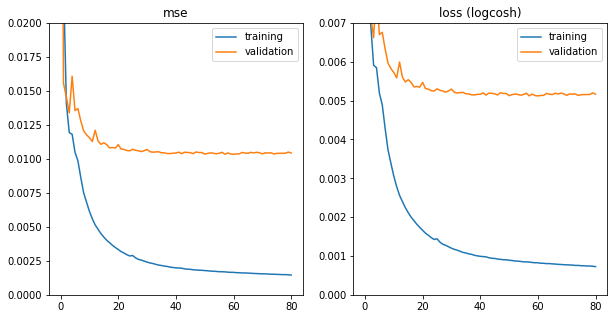

In [29]:
file = "learning"
history_fig(history, file, sfolder, loss)

In [30]:
def save_model(model, file_train, sfolder):
    file = sfolder + "/" + "model_tree.png"
    print("save_file:", file)
    plot_model(model, to_file=file, show_shapes=True)
    # model.summary()

In [31]:
save_model(model, file, sfolder)

save_file: result/2020_1204_182942_elip30_12_4_train20000_test2000/202012240402-03/model_tree.png


In [32]:
epochs = len(history.history['mse'])
score = model.evaluate(x=xt, y=yt)
mse_score = np.mean((yt - y_pred) ** 2)
rmse_score = np.sqrt(np.mean((yt - y_pred) ** 2))
mae_score = np.mean(np.abs(yt - y_pred))
rmae_score = np.sqrt(np.mean(np.abs(yt - y_pred)))
print("test_MSE: ", mse_score)
print("test_RMSE: ", rmse_score)
print("test_MAE: ", mae_score)
print("test_RMAE: ", rmae_score)
print("test_LOSS: ", score[0])

63/63 [==============================] - 0s 6ms/step - loss: 0.0051 - mse: 0.0103
test_MSE:  0.010340617255005066
test_RMSE:  0.10168882561523201
test_MAE:  0.07218966077198595
test_RMAE:  0.26868133685089846
test_LOSS:  0.005122234113514423


In [33]:
def make_fig_one_pair_abs(x, temp, sfolder, text=""):
    temp_list = np.array([temp, temp+1, temp+2, temp+3])
    n = len(x) + 2
    print("x shape: ", np.shape(x[0]))

    f_vmin = x[1][temp:temp+4, 0].min()
    f_vmax = x[1][temp:temp+4, 0].max()
    fd_vmin = x[2][temp:temp+4, 0].min()
    fd_vmax = x[2][temp:temp+4, 0].max()
    g_vmin = np.abs(x[0][temp:temp+4, 0]).min()
    g_vmax = np.abs(x[0][temp:temp+4, 0]).max()

    fig = plt.figure(figsize=(30,20))
    for i, j in enumerate(temp_list):
        for k in range(n):
            ax = fig.add_subplot(4, n, (n * i) + k + 1)
            if k == 0:
                ax.set_title("g", fontsize=26)
                ax.set_xticks([], minor=False)
                ax.set_yticks([], minor=False)
                ax.imshow(np.abs(x[k][j, 0, :, :]), vmin=g_vmin, vmax=g_vmax)
            elif k == 1:
                ax.set_title("f", fontsize=26)
                ax.set_xticks([], minor=False)
                ax.set_yticks([], minor=False)
                ax.imshow(x[k][j, 0, :, :], vmin=f_vmin, vmax=f_vmax)
            elif k == 2:
                ax.set_title("f'", fontsize=26)
                ax.set_xticks([], minor=False)
                ax.set_yticks([], minor=False) 
                ax.imshow(x[k][j, 0, :, :], vmin=f_vmin, vmax=f_vmax)
            elif k == 3:
                ax.set_title("f - f'", fontsize=26)
                ax.set_xticks([], minor=False)
                ax.set_yticks([], minor=False)
                ax.imshow(x[1][j, 0, :, :] - x[2][j, 0, :, :], vmin=f_vmin, vmax=f_vmax)
            elif k == 4:
                ax.set_title("f'", fontsize=26)
                ax.set_xticks([], minor=False)
                ax.set_yticks([], minor=False) 
                ax.imshow(x[2][j, 0, :, :], vmin=fd_vmin, vmax=fd_vmax)

    f_cbar_ax = fig.add_axes([0.74, 0.13, 0.02, 0.75])
    f_norm = colors.Normalize(vmin=f_vmin, vmax=f_vmax)
    f_mappable = ScalarMappable(norm=f_norm)
    fig.colorbar(f_mappable, cax=f_cbar_ax)

    fd_cbar_ax = fig.add_axes([0.9, 0.13, 0.02, 0.75])
    fd_norm = colors.Normalize(vmin=fd_vmin, vmax=fd_vmax)
    fd_mappable = ScalarMappable(norm=fd_norm)
    fig.colorbar(fd_mappable, cax=fd_cbar_ax)

    g_cbar_ax = fig.add_axes([0.26, 0.13, 0.02, 0.75])
    g_norm = colors.Normalize(vmin=g_vmin, vmax=g_vmax)
    g_mappable = ScalarMappable(norm=g_norm)
    fig.colorbar(g_mappable, cax=g_cbar_ax)

    file = sfolder + "/" + "in_out_figs_" + text + "_".join(str(temp_list)) + ".png"
    print(file)
    plt.savefig(file)
    plt.close()

In [34]:
np.shape(old_yt)

(2000, 1, 64, 64)

In [35]:
y_pred_2d = y_pred.reshape(-1, 1, np.shape(old_yt)[2], np.shape(old_yt)[3])
plot_num_list = [0,100,200,300,400,500,600,700,800,900]
for i in plot_num_list:
    if "__" in reshape_type:
        make_fig_one_pair_abs((old_xt[0], old_yt, y_pred_2d), i, sfolder, "pred")
    else:
        make_fig_one_pair_abs((old_xt, old_yt, y_pred_2d), i, sfolder, "pred")

x shape:  (2000, 2, 16, 16)
result/2020_1204_182942_elip30_12_4_train20000_test2000/202012240402-03/in_out_figs_pred[_0_ _1_ _2_ _3_].png
x shape:  (2000, 2, 16, 16)
result/2020_1204_182942_elip30_12_4_train20000_test2000/202012240402-03/in_out_figs_pred[_1_0_0_ _1_0_1_ _1_0_2_ _1_0_3_].png
x shape:  (2000, 2, 16, 16)
result/2020_1204_182942_elip30_12_4_train20000_test2000/202012240402-03/in_out_figs_pred[_2_0_0_ _2_0_1_ _2_0_2_ _2_0_3_].png
x shape:  (2000, 2, 16, 16)
result/2020_1204_182942_elip30_12_4_train20000_test2000/202012240402-03/in_out_figs_pred[_3_0_0_ _3_0_1_ _3_0_2_ _3_0_3_].png
x shape:  (2000, 2, 16, 16)
result/2020_1204_182942_elip30_12_4_train20000_test2000/202012240402-03/in_out_figs_pred[_4_0_0_ _4_0_1_ _4_0_2_ _4_0_3_].png
x shape:  (2000, 2, 16, 16)
result/2020_1204_182942_elip30_12_4_train20000_test2000/202012240402-03/in_out_figs_pred[_5_0_0_ _5_0_1_ _5_0_2_ _5_0_3_].png
x shape:  (2000, 2, 16, 16)
result/2020_1204_182942_elip30_12_4_train20000_test2000/20201224

In [38]:
file = sfolder + "/output_valid.json"
with open(file, "w") as f:
    memo = {
            "folder": str(sfolder),
            "train_data_num": str(train_num),
            "valid_data_num": str(test_num),
            "epochs": str(epochs),
            "valid_MSE": str(mse_score),
            "valid_RMSE": str(rmse_score),
            "valid_MAE": str(mae_score),
            "valid_RMAE": str(rmae_score),
            "valid_LOSS": str(score[0]),
            "active_func": str(active_function),
            "reshape_type": str(reshape_type),
            "noise_rate": str(noise_rate),
            "is_normalization": str(is_normalization),
            "is_one_bias": str(is_one_bias),
            "optimizer": str(optimizer),
            "loss": str(loss)
            }
    json.dump(memo, f, indent=4)

In [40]:
with open("result/test/test_x.pkl", 'rb') as f:
    test_x = pickle.load(f)

with open("result/test/test_y.pkl", 'rb') as f:
    test_y = pickle.load(f)

In [41]:
test_pred_y = model.predict(test_x)

In [42]:
test_score = model.evaluate(x=test_x, y=test_y)
test_mse_score = np.mean((test_y - test_pred_y) ** 2)
test_rmse_score = np.sqrt(np.mean((test_y - test_pred_y) ** 2))
test_mae_score = np.mean(np.abs(test_y - test_pred_y))
test_rmae_score = np.sqrt(np.mean(np.abs(test_y - test_pred_y)))
print("test_MSE: ", test_mse_score)
print("test_RMSE: ", test_rmse_score)
print("test_MAE: ", test_mae_score)
print("test_RMAE: ", test_rmae_score)
print("test_LOSS: ", test_score[0])

157/157 [==============================] - 1s 6ms/step - loss: 0.0053 - mse: 0.0108
test_MSE:  0.01078103137226155
test_RMSE:  0.10383174549366658
test_MAE:  0.07475382336384925
test_RMAE:  0.27341145433915026
test_LOSS:  0.005338170565664768


In [44]:
file = sfolder + "/output_test.json"
with open(file, "w") as f:
    memo = {
            "folder": str(sfolder),
            "train_data_num": str(train_num),
            "valid_data_num": str(test_num),
            "test_data_num": str(len(test_y)),
            "epochs": str(epochs),
            "test_MSE": str(test_mse_score),
            "test_RMSE": str(test_rmse_score),
            "test_MAE": str(test_mae_score),
            "test_RMAE": str(test_rmae_score),
            "test_LOSS": str(test_score[0]),
            "active_func": str(active_function),
            "reshape_type": str(reshape_type),
            "noise_rate": str(noise_rate),
            "is_normalization": str(is_normalization),
            "is_one_bias": str(is_one_bias),
            "optimizer": str(optimizer),
            "loss": str(loss)
            }
    json.dump(memo, f, indent=4)

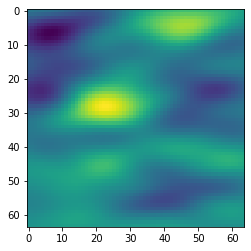

In [45]:
plt.figure()
plt.imshow(y_pred_2d[3][0])
plt.show()

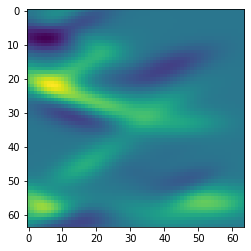

In [46]:
plt.figure()
plt.imshow(old_y[1][0])
plt.show()

In [ ]:
plt.figure()
plt.imshow(x[0][0].transpose(2,0,1)[1])
plt.show()

In [ ]:
# with open("result/evaluation/eval_x.pkl", 'wb') as f:
#     pickle.dump(x, f)

# with open("result/evaluation/eval_y.pkl", 'wb') as f:
#     pickle.dump(y, f)